In [ ]:
!gdown 11gpLZOKw5-kJjYEaSaj613zaCA51eXVH
!unzip down_imagenet.zip -d down_imagenet

Streaming output truncated to the last 5000 lines.
  inflating: down_imagenet/train/car/car_0443.jpg  
  inflating: down_imagenet/train/car/car_0444.jpg  
  inflating: down_imagenet/train/car/car_0445.jpg  
  inflating: down_imagenet/train/car/car_0446.jpg  
  inflating: down_imagenet/train/car/car_0447.jpg  
  inflating: down_imagenet/train/car/car_0448.jpg  
  inflating: down_imagenet/train/car/car_0449.jpg  
  inflating: down_imagenet/train/car/car_0450.jpg  
  inflating: down_imagenet/train/car/car_0451.jpg  
  inflating: down_imagenet/train/car/car_0452.jpg  
  inflating: down_imagenet/train/car/car_0453.jpg  
  inflating: down_imagenet/train/car/car_0454.jpg  
  inflating: down_imagenet/train/car/car_0455.jpg  
  inflating: down_imagenet/train/car/car_0456.jpg  
  inflating: down_imagenet/train/car/car_0457.jpg  
  inflating: down_imagenet/train/car/car_0458.jpg  
  inflating: down_imagenet/train/car/car_0459.jpg  
  inflating: down_imagenet/train/car/car_0460.jpg  
  inflating: 

In [ ]:
import os, random, string, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


# def genData(datapath, savepath):
#     with open(datapath) as fh:
#         for row in fh.read().split('\n')[1:]:
#             try:
#                 row = tuple(map(lambda val: int(float(val)), row.split(',')))
#             except:
#                 continue
#             label, img = row[0], Image.fromarray(np.reshape(row[1:], (28,28)))
#             path = savepath+'/'+str(label)
#             if not os.path.exists(path):
#                 os.makedirs(path)
#             img.save(path+'/'+''.join(random.choice(string.ascii_letters) for i in range(10))+'.png')
# 
# https://stackoverflow.com/questions/62581171/how-to-implement-kaze-and-a-kaze-using-python-and-opencv
#
# train = genData('Downloads/New folder/sign_mnist_train/sign_mnist_train.csv', 'sign_mnist/train/')
# test = genData('Downloads/New folder/sign_mnist_test/sign_mnist_test.csv', 'sign_mnist/test/')

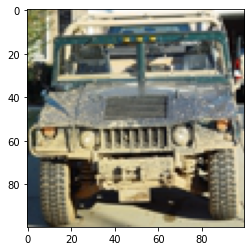

In [ ]:
plt.imshow(Image.open('/content/down_imagenet/train/car/car_0000.jpg'))
plt.show()

error: ignored

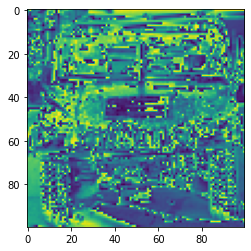

In [44]:
def single_channel_image(img):
  (B, G, R) = cv2.split(img)
  return B+G+R

plt.imshow(single_channel_image(cv2.imread('/content/down_imagenet/train/car/car_0000.jpg')))

In [46]:
datasetdir = '/content/down_imagenet'
import os
os.chdir(datasetdir)

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        datasetdir+'/train/',
        target_size = (height, width), 
        class_mode = 'categorical',
        batch_size = batch_size
    )

    val_dataset = imgdatagen.flow_from_directory(
        datasetdir+'/test/',
        target_size = (height, width), 
        class_mode = 'categorical',
        batch_size = batch_size
    )
    return train_dataset, val_dataset

In [48]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    
    plt.show()

In [49]:
resnet50 = keras.applications.resnet50
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False)
conv_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [50]:
def preprocess_input(img): #appling on the dataset
  img = np.array(img, dtype=np.uint8)
  query_img = single_channel_image(img)
  query_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  akaze=cv2.AKAZE_create()
  queryKeypoints, queryDescriptors = akaze.detectAndCompute(query_img,None)
  img = cv2.drawKeypoints(img,queryKeypoints,outImage = None,color=(255,0,0), flags=0)
  return resnet50.preprocess_input(img)

In [51]:
train_dataset, val_dataset = generators((100, 100), preprocessing=preprocess_input)

Found 5959 images belonging to 8 classes.
Found 940 images belonging to 8 classes.


In [52]:
conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [53]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(conv_model.output)
# hidden layers
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dense(256, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
# softmax
predictions = keras.layers.Dense(24, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
full_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']       

In [54]:
for layer in conv_model.layers:
    layer.trainable = False

In [ ]:
full_model.summary()

In [57]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(lr=0.001),
                  metrics=['acc'])
early_stopping = keras.callbacks.EarlyStopping('val_loss', mode='auto', patience=2)
history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    steps_per_epoch = 45,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10


InvalidArgumentError: ignored

In [39]:
plot_history(history, yrange=(0.9,1))

NameError: ignored

In [ ]:
full_model.save('/content/model.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
def predict_class(model, img_path, input_shape, class_indices=None):
    class_indices = {value: key for key, value in class_indices.items()} if class_indices else None
    data = np.expand_dims(preprocess_input(cv2.resize(cv2.imread(img_path), input_shape)), axis=0)
    return class_indices.get(np.argmax(model.predict(data))) if class_indices else model.predict(data)

predict_class(full_model, "/content/sign_mnist/test/15/AktgOSSxjQ.png", (32, 32), class_indices=train_dataset.class_indices)

'23'